In [2]:
import os
import random
import re
import shutil
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

import infineac.file_loader as file_loader
import infineac.helper as helper
import infineac.process_event as process_event
import infineac.process_text as process_text
import infineac.topic_extractor as topic_extractor
import infineac.constants as constants

%load_ext autoreload
%autoreload 2

PATH_DIR = "../data/transcripts/"
random.seed(111)

/Users/Foal/miniconda3/envs/infineac/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/Foal/miniconda3/envs/infineac/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/Foal/miniconda3/envs/infineac/lib/python3.10/site-packages/

## Load NLP model

In [3]:
import spacy_stanza
nlp_stanza = spacy_stanza.load_pipeline("en", processors="tokenize, lemma")
nlp_stanza.add_pipe('sentencizer')

2023-09-18 09:27:42 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-09-18 09:27:43 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| lemma     | combined |

2023-09-18 09:27:43 WARNING: GPU requested, but is not available!
2023-09-18 09:27:43 INFO: Using device: cpu
2023-09-18 09:27:43 INFO: Loading: tokenize
2023-09-18 09:27:43 INFO: Loading: lemma
2023-09-18 09:27:43 INFO: Done loading processors!


## Load Files

Load all xml files from the given directory and return a list of corresponding events.

In [3]:
# files = [Path("../data/transcripts/2022/15203138_T.xml")]
files = list(Path(PATH_DIR).rglob("*.xml"))
events = file_loader.load_files_from_xml(files)

Files: 100%|██████████| 43578/43578 [06:09<00:00, 117.80it/s]


Check if all positions are valid

In [4]:
process_event.test_positions(events)

## Filter data

Filter out all events that are not in the given time range and do not include the given keywords.

In [5]:
events_filt_all = process_event.filter_events(events, year = 2022, keywords = {"russia":1, "ukraine":1}, modifier_words=[])
events_filt = process_event.filter_events(events, year = 2022, keywords = {"russia":1, "ukraine":1})
len(events_filt)

Filtering events


Events: 100%|██████████| 43578/43578 [00:14<00:00, 3069.87it/s]


Filtering events


Events: 100%|██████████| 43578/43578 [03:35<00:00, 202.15it/s]


9559

In [6]:
helper.save_data(events_filt, "data/events_filt", compression="lz4")

List all events, that are filtered out due to modifier words preceding the keywords.

In [33]:
events_filtered_filter_words = []
ids_filtered_events = []
for i, event in enumerate(events_filt):
    ids_filtered_events.append(event['id'])
for event in events_filt_all:
    if event['id'] not in ids_filtered_events:
        events_filtered_filter_words.append(event)
print(len(events_filtered_filter_words))
process_event.extract_passages_from_events(events_filtered_filter_words, keywords=["russia", "ukraine"], modifier_words=[], nlp_model=nlp_stanza)

0
Extracting passages from events


Events: 0it [00:00, ?it/s]


[]

## Exploration

In [34]:
file = [event['file'] for event in events_filt]
id = [event['id'] for event in events_filt]
year_upload = [event['year_upload'] for event in events_filt]
company = [event['company_name'] for event in events_filt]
ticker = [event['company_ticker'] for event in events_filt]
ticker_new = [re.sub('\\..*', '', t) for t in ticker]
dates = [event['date'] for event in events_filt if "date" in event.keys()]
numeric_values = mdates.date2num(dates)

russia_and_sanction = [process_text.get_russia_and_sanction(event['qa_collapsed'] + event['presentation_collapsed']) for event in events_filt]
election = [process_text.get_elections(event['qa_collapsed'] + event['presentation_collapsed']) for event in events_filt]
russia_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('russia') for event in events_filt]
sanction_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('sanction') for event in events_filt]

Create a DataFrame with the following columns:

In [35]:
df = pd.DataFrame({'file': file,
                   'year_upload': year_upload,
                   'company': company,
                   'ticker':ticker,
                   'ticker_new': ticker_new,
                   'date': dates,
                   'dates_num' : numeric_values,
                   'russia': russia_and_sanction,
                   'russia_count': russia_count,
                   'sanction_count': sanction_count,
                   'election': election})

Count the number of occasions where the word "russia" (and "sanction") appears in the earnings call.

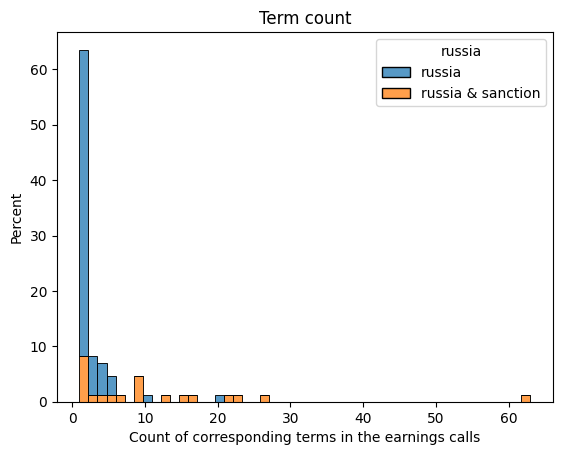

In [36]:
sns.histplot(df[df['russia_count']>=1], x='russia_count', hue="russia", bins=50, stat="percent", common_norm=True, multiple="stack")
plt.xlabel('Count of corresponding terms in the earnings calls')
plt.ylabel('Percent')
plt.title('Term count')
plt.show()

Average mentions of "russia" per earnings call.

In [37]:
np.array(russia_count).mean()

3.288135593220339

Average mentions of "russia" per earnings call if "russia" is mentioned at
least once.

In [38]:
np.array([el for el in russia_count if el > 0]).mean()

4.564705882352941

Average mentions of "sanction" per earnings call.

In [39]:
np.array([el for el in sanction_count if el > 0]).mean()

2.4347826086956523

Event distribution over time highlighting the different categories.

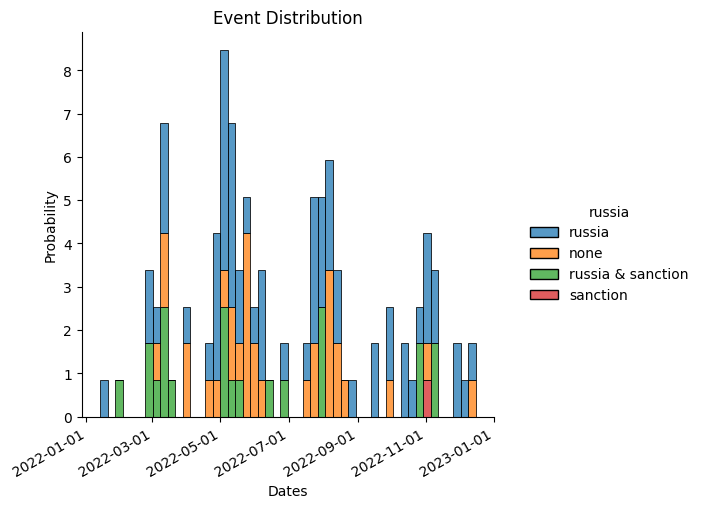

In [40]:
# plt.hist(numeric_values, bins=50)
# sns.histplot(numeric_values, bins=50)
sns.displot(df, x="dates_num", hue="russia", bins=50, stat="percent", common_norm=True, multiple="stack")
# plt.plot_date(dates, numeric_values, '-o')  # '-o' adds markers on the data points
plt.xlabel('Dates')
plt.ylabel('Probability')
plt.title('Event Distribution')

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.show()

Event proportion over time highlighting the different categories.

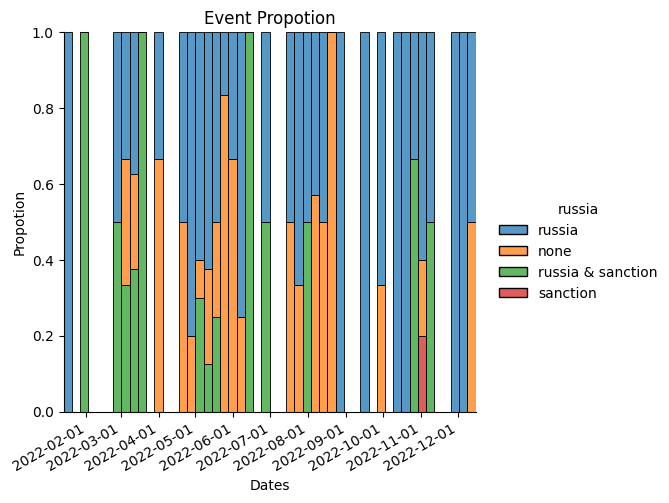

In [41]:
# plt.hist(numeric_values, bins=50)
# sns.histplot(numeric_values, bins=50)
sns.displot(df, x="dates_num", hue="russia", bins=50, stat="proportion", common_norm=True, multiple="fill")
# plt.plot_date(dates, numeric_values, '-o')  # '-o' adds markers on the data points
plt.xlabel('Dates')
plt.ylabel('Propotion')
plt.title('Event Propotion')

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.show()

## Preprocess and extract corpus

In [3]:
events_filt = helper.load_data("data/events_filt.lz4")

Create different types of corpora:
1. Corpus with a window of 1 sentence and not joining adjacent sentences.
2. Corpus with a window of 1 sentence and joining adjacent sentences.
3. Corpus with a window of 3 sentences and joining adjacent sentences.
4. Corpus with a window of 5 sentences and joining adjacent sentences.
5. Corpus with a window that includes the whole paragraph from the keywords on.

In [7]:
corpus_window_0_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=0,
    subsequent_paragraphs=0,
    join_adjacent_sentences=False,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
corpus_window_0_df.head()

Extracting passages from events


Events:   0%|          | 0/9559 [00:00<?, ?it/s]

Events: 100%|██████████| 9559/9559 [29:04<00:00,  5.48it/s]  


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 37873/37873 [14:33<00:00, 43.35it/s]


event_idx,presentation_and_qa_idx,part_idx,paragraph_idx,sentence_idx,text,processed_text,id,years_upload,date,company_name
i64,i64,i64,i64,i64,str,str,i64,i64,datetime[μs],str
0,0,0,0,0,"""I want to begi…","""want begin rem…",14973682,2022,2022-04-27 13:00:00,"""CGI Inc"""
0,0,0,0,1,"""CGI does not h…","""cgi client pro…",14973682,2022,2022-04-27 13:00:00,"""CGI Inc"""
0,0,0,0,2,"""However, we do…","""employee famil…",14973682,2022,2022-04-27 13:00:00,"""CGI Inc"""
0,1,0,0,0,"""Conversely, yo…","""conversely get…",14973682,2022,2022-04-27 13:00:00,"""CGI Inc"""
1,0,0,0,0,"""We have inflat…","""inflationary e…",15228018,2022,2022-05-24 10:00:00,"""Schneider Elec…"


In [156]:
corpus_window_0_join_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=0,
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
    remove_additional_words=True,
)
len(corpus_window_0_join_df)

Extracting passages from events


Events: 100%|██████████| 11865/11865 [26:53<00:00,  7.35it/s] 


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 39217/39217 [12:27<00:00, 52.45it/s] 


39217

In [173]:
corpus_window_3_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=[0,3],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
    remove_additional_words=True,
)
len(corpus_window_3_df)

Extracting passages from events


Events: 100%|██████████| 11865/11865 [25:40<00:00,  7.70it/s] 


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 36099/36099 [17:48<00:00, 33.80it/s] 


36099

In [174]:
corpus_window_5_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=[0,5],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
    remove_additional_words=True,
)
len(corpus_window_5_df)

Extracting passages from events


Events: 100%|██████████| 11865/11865 [26:31<00:00,  7.46it/s] 


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 35752/35752 [17:56<00:00, 33.20it/s]


35752

In [175]:
corpus_window_whole_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=[0,-1],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
    remove_additional_words=True,
)
len(corpus_window_whole_df)

Extracting passages from events


Events: 100%|██████████| 11865/11865 [26:06<00:00,  7.57it/s] 


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 35848/35848 [21:00<00:00, 28.45it/s] 


35848

Save and load data

In [10]:
helper.save_data(corpus_window_0_df, "data/corpus_window_0_df_no_answer", compression="lz4")
# helper.save_data(corpus_window_0_join_df, "corpus_window_0_join_df_no_answer", compression="lz4")
# helper.save_data(corpus_window_3_df, "corpus_window_3_join_df_no_answer", compression="lz4")
# helper.save_data(corpus_window_5_df, "corpus_window_5_join_df_no_answer", compression="lz4")
# helper.save_data(corpus_window_whole_df, "corpus_window_whole_join_df_no_answer", compression="lz4")

In [4]:
corpus_window_0_df = helper.load_data("data/corpus_window_0_df_no_answer.lz4")
# corpus_window_0_join_df = helper.load_data("corpus_window_0_join_df_no_answer.lz4")
# corpus_window_3_df = helper.load_data("corpus_window_3_join_df_no_answer.lz4")
# corpus_window_5_df = helper.load_data("corpus_window_5_join_df_no_answer.lz4")
# corpus_window_whole_df = helper.load_data("corpus_window_whole_join_df_no_answer.lz4")

## Extract Strategies

In [5]:
corpus_window_0_df = process_text.get_strategies(dataframe=corpus_window_0_df)
# corpus_window_0_df.groupby('id').agg(pl.col('exit_strategy', 'stay_strategy', 'adaptation_strategy').sum(), pl.col('text', 'processed_text')).sort('id')
corpus_window_0_join_df = process_text.get_strategies(dataframe=corpus_window_0_join_df)
corpus_window_3_df = process_text.get_strategies(dataframe=corpus_window_3_df)
corpus_window_5_df = process_text.get_strategies(dataframe=corpus_window_5_df)
corpus_window_whole_df = process_text.get_strategies(dataframe=corpus_window_whole_df)

event_idx,presentation_and_qa_idx,part_idx,paragraph_idx,sentence_idx,text,processed_text,id,years_upload,date,company_name,exit_strategy,stay_strategy,adaptation_strategy
i64,i64,i64,i64,i64,str,str,i64,i64,datetime[μs],str,bool,bool,bool
0,0,0,0,0,"""I want to begi…","""want begin rem…",14973682,2022,2022-04-27 13:00:00,"""CGI Inc""",false,false,false
0,0,0,0,1,"""CGI does not h…","""cgi client pro…",14973682,2022,2022-04-27 13:00:00,"""CGI Inc""",false,false,false
0,0,0,0,2,"""However, we do…","""employee famil…",14973682,2022,2022-04-27 13:00:00,"""CGI Inc""",false,false,false
0,1,0,0,0,"""Conversely, yo…","""conversely get…",14973682,2022,2022-04-27 13:00:00,"""CGI Inc""",true,false,false
1,0,0,0,0,"""We have inflat…","""inflationary e…",15228018,2022,2022-05-24 10:00:00,"""Schneider Elec…",false,false,false


In [57]:
sum(corpus_window_0_df['exit_strategy'])

3399

### Analyse corpus

In [31]:
lengths = [len(doc) for doc in corpus_window_0_df['processed_text'].to_list()]
np.argmax(np.array(lengths))

4893

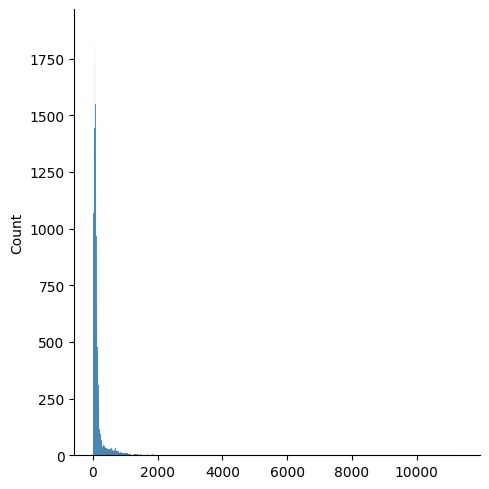

In [32]:
sns.displot(np.array(lengths))

## Extract topics

In [6]:
from bertopic.representation import KeyBERTInspired
# from bertopic.representation import PartOfSpeech
from bertopic.representation import MaximalMarginalRelevance
from transformers import pipeline
# from bertopic.representation import TextGeneration
# from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer

# vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words="english", min_df=10)


# main_representation = KeyBERTInspired()
inspired_model = KeyBERTInspired()

# sentence model
# sentence_model = SentenceTransformer("all-mpnet-base-v2")
sentence_model_light = SentenceTransformer("all-MiniLM-L6-v2")

# mmr model
mmr_model = MaximalMarginalRelevance(diversity=0.4)

# pos model
# nlp_stanza_pos = spacy_stanza.load_pipeline("en", processors="tokenize, pos")
# pos_model = PartOfSpeech(nlp_stanza_pos)

# Create a generator model
# prompt = "I have a topic described by the following keywords: [KEYWORDS]. Based on the previous keywords, what is this topic about?"
# generator = pipeline('text2text-generation', model='google/flan-t5-base')
# generator_model = TextGeneration(generator)

# chain models
chain_model_1 = [inspired_model, mmr_model]
# chain_model_2 = [inspired_model, mmr_model, pos_model]
# chain_model_3 = [inspired_model, pos_model, mmr_model]
# generator_chain_model_1 = [inspired_model, mmr_model, generator_model]
# generator_chain_model_2 = [inspired_model, mmr_model, pos_model, generator_model]


# Add all models together to be run in a single `fit`
representation_model = {
   "Main": inspired_model,
   # "Pos":  pos_model,
   "Chain: Inspired - MMR":  chain_model_1,
   # "Chain: Inspired - MMR - POS":  chain_model_2,
   # "Chain: Inspired - POS - MMR":  chain_model_3,
   # "Generator": generator_model,
   # "Generator chain: Inspired - MMR": generator_chain_model_1,
   # "Generator chain: Inspired - MMR - POS": generator_chain_model_2
}

### 1 - Only sentence
* Sentence window: 0
* No join

In [51]:
corpus, bridge = process_text.remove_sentences_under_threshold(corpus_window_0_df['processed_text'].to_list())
topic_model_0, topics_0, probs_0 = topic_extractor.bert_advanced(corpus, representation_model=representation_model, embedding_model=sentence_model_light)

Batches:   0%|          | 0/1152 [00:00<?, ?it/s]

2023-09-18 11:49:51,922 - BERTopic - Transformed documents to Embeddings
2023-09-18 11:50:34,181 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-09-18 11:55:01,518 - BERTopic - Clustered reduced embeddings


Group the topics according to the predefined categories.

In [258]:
topics_0_filled = helper.fill_list_from_mapping(topics_0, bridge, -2)
groups_0 = topic_extractor.categorize_topics(topic_model_0.get_topic_info()['Chain: Inspired - MMR'].to_list())
groups_0 = groups_0.hstack(pl.DataFrame(topic_model_0.get_topic_info())[['Count', 'Name', "Representative_Docs"]])
topics_df = topic_extractor.map_topics_to_categories(topics_0_filled, groups_0)
groups_0.filter(pl.col("n")!=-1).groupby(("category")).agg(pl.col("Count").sum()).sort("Count", descending=True)

category,Count
str,i64
"""commodity""",2738
"""indirect geogr…",2720
"""finance""",2606
"""macro demand""",2531
"""other""",1744
"""macro inflatio…",1458
"""supply chain""",1448
"""humanitarian""",1236
"""energy""",835


In [259]:
# corpus_window_0_df = corpus_window_0_df.drop(columns=['topic', "year", "category", "keywords", "Count", "Name", "Representative_Docs"])
corpus_window_0_df = corpus_window_0_df.with_columns(pl.Series('year', corpus_window_0_df['date'].dt.year()))
corpus_window_0_df = corpus_window_0_df.hstack(topics_df)

In [270]:
corpus_window_0_df_agg = topic_extractor.get_topics_per_company(corpus_window_0_df)
corpus_window_0_df_agg[["company_name", "year", "exit_strategy", "stay_strategy", "adaptation_strategy", "topic", "category"]].write_excel("data/topics_comp_0.xlsx")

#### Hierarchical clustering

In [147]:
hierarchical_topics = topic_model_0.hierarchical_topics(corpus_window_0_df['processed_text'].to_list())
topics_grouped = topic_extractor.get_groups_from_hierarchy(hierarchical_topics, 10)

In [12]:
topic_model_0.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

### 2 - Only sentence - join
* Sentence window: 0
* Join sentences

In [ ]:
corpus, bridge = process_text.remove_sentences_under_threshold(corpus_window_0_join_df['processed_text'].to_list())
topic_model_0_join, topics_0_join, probs_0_join = topic_extractor.bert_advanced(corpus, representation_model=representation_model, embedding_model=sentence_model_light)

Batches:   0%|          | 0/1152 [00:00<?, ?it/s]

2023-09-18 11:49:51,922 - BERTopic - Transformed documents to Embeddings
2023-09-18 11:50:34,181 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-09-18 11:55:01,518 - BERTopic - Clustered reduced embeddings


Group the topics according to the predefined categories.

In [ ]:
topics_0_join_filled = helper.fill_list_from_mapping(topics_0_join, bridge, -2)
groups_0_join = topic_extractor.categorize_topics(topic_model_0.get_topic_info()['Chain: Inspired - MMR'].to_list())
groups_0_join = groups_0_join.hstack(pl.DataFrame(topic_model_0.get_topic_info())[['Count', 'Name', "Representative_Docs"]])
topics_df = topic_extractor.map_topics_to_categories(topics_0_join_filled, groups_0_join)
groups_0_join.filter(pl.col("n")!=-1).groupby(("group")).agg(pl.col("Count").sum()).sort("Count", descending=True)

group,Count
str,i64
"""commodity""",2738
"""indirect geogr…",2720
"""finance""",2606
"""macro demand""",2531
"""other""",1744
"""macro inflatio…",1458
"""supply chain""",1448
"""humanitarian""",1236
"""energy""",835


In [ ]:
# corpus_window_0_join_df = corpus_window_0_df.drop(columns=['topic', "year", "group", "keywords"])
corpus_window_0_join_df = corpus_window_0_df.with_columns(pl.Series('year', corpus_window_0_join_df['date'].dt.year()))
corpus_window_0_join_df = corpus_window_0_df.hstack(topics_df)

In [ ]:
corpus_window_0_join_df_agg = topic_extractor.get_topics_per_company(corpus_window_0_df)
corpus_window_0_join_df_agg[["company_name", "year", "exit_strategy", "stay_strategy", "adaptation_strategy", "topic", "category"]].write_excel("data/topics_comp_0_join.xlsx")

company_name,year,exit_strategy,stay_strategy,adaptation_strategy,text,processed_text,topic,group
str,i32,u32,u32,u32,list[str],list[str],list[i64],list[str]
"""01 Communique …",2022,0,0,0,"[""And so in fact, Q-Day has already arrived at a national level, such as the U.S., China, Russia, this has already arrived."", ""Now would you believe -- the very fundamental question is, would you believe a country like U.S., Russia and China will not go into one of the quantum computer vendors and say something like, ""Here's $2 billion."", … ""Firstly, obvious, the war in Ukraine is the first time cyberwarfare has been embedded in the major global contract.""]","[""fact q day arrive national level u.s. arrive"", ""believe fundamental believe country like u.s. quantum computer vendor like"", … ""firstly obvious time cyberwarfare embed major global contract""]",[50],"[""cybersecurity"", ""standard""]"
"""180 Degree Cap…",2022,1,1,0,"[""COVID supply chain issues, inflation, higher rates and the human tragedy we are living through with the Russia invasion of the Ukraine."", ""I think what's happening in Russia and Ukraine only helps them because we're now worried about food shortages and the rest."", … ""It was an across-the-board selling type of quarter, indiscriminate selling, if I have to call it something, or almost every name we own as investors were trying to make sense of a world where high inflation, Fed determined to ratchet rates higher to equivalent inflation, continued supply chain issues, Russian war with Ukraine, very difficult backdrop for the market as all of you know.""]","[""supply chain issue inflation high rate human tragedy live"", ""think happen help worried food shortage rest"", … ""board type indiscriminate investor try sense world high inflation fed determine ratchet rate high equivalent inflation supply chain issue difficult backdrop market know""]","[12, 40, … 86]","[""other"", ""commodity"", … ""finance""]"
"""1847 Goedeker …",2022,0,0,0,"[""There's a lot of things going on from the war in Ukraine, inflation, fuel surcharges.""]","[""lot thing go inflation fuel surcharge""]",[],"[""standard""]"
"""2020 Bulkers L…",2022,1,0,0,"[""However, the volume declines are being offset by, to a large extent, increased trading distances, where, for example, we're seeing coal moving from Asia to Europe to replace Russian coals."", ""Then I think, other things that is giving some support to the market is, of course, although volumes are not necessarily up from last year because last year was a strong year, but the ton-mile changes we're seeing on the coal side in light of the Ukraine war, and I guess the general energy crisis."", ""But now with -- because this situation is evolving almost day by day, if Russia is not sending gas to Poland, I'm quite sure that some of the guys in Asia with import contracts are going to be diverting some cargoes to Europe to sell that at a bigger premium, which again, would be supporting for coal demand.""]","[""volume decline offset large extent increase trading distance example see coal move asia europe replace coal"", ""think thing give support market course volume necessarily strong ton mile change see coal light general energy"", ""situation evolve day day send gas poland sure guy asia import contract go diverting cargo europe big premium support coal demand""]","[25, 234]","[""standard"", ""transport"", ""macro demand""]"
"""3D Systems Cor…",2022,9,2,0,"[""In Europe, the war in Ukraine and uncertainty regarding recession and energy supplies continue to pressure our customers."", ""On our second quarter earnings call, we highlighted 2 additional items that had an adverse impact on our year-over-year revenue growth, one being the Russia-Ukraine conflict and the other being persistent supply chain disruptions."", … ""The higher non-GAAP operating expenses reflect the impact of divestitures, offset by higher spending in targeted areas to support future growth, including research and development

### 3 - 3 sentences - join
* Sentence window: 3
* Join sentences  

In [ ]:
corpus, bridge = process_text.remove_sentences_under_threshold(corpus_window_3_df['processed_text'].to_list())
topic_model_3, topics_3, probs_3 = topic_extractor.bert_advanced(corpus, representation_model=representation_model, embedding_model=sentence_model_light)

Batches:   0%|          | 0/1152 [00:00<?, ?it/s]

2023-09-18 11:49:51,922 - BERTopic - Transformed documents to Embeddings
2023-09-18 11:50:34,181 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-09-18 11:55:01,518 - BERTopic - Clustered reduced embeddings


Group the topics according to the predefined categories.

In [ ]:
topics_3_filled = helper.fill_list_from_mapping(topics_3, bridge, -2)
groups_3 = topic_extractor.categorize_topics(topic_model_3.get_topic_info()['Chain: Inspired - MMR'].to_list())
groups_3 = groups_3.hstack(pl.DataFrame(topic_model_3.get_topic_info())[['Count', 'Name', "Representative_Docs"]])
topics_df = topic_extractor.map_topics_to_categories(topics_3_filled, groups_3)
groups_3.filter(pl.col("n")!=-1).groupby(("group")).agg(pl.col("Count").sum()).sort("Count", descending=True)

group,Count
str,i64
"""commodity""",2738
"""indirect geogr…",2720
"""finance""",2606
"""macro demand""",2531
"""other""",1744
"""macro inflatio…",1458
"""supply chain""",1448
"""humanitarian""",1236
"""energy""",835


In [ ]:
# corpus_window_3_df = corpus_window_0_df.drop(columns=['topic', "year", "group", "keywords"])
corpus_window_3_df = corpus_window_3_df.with_columns(pl.Series('year', corpus_window_3_join_df['date'].dt.year()))
corpus_window_3_df = corpus_window_3_df.hstack(topics_df)

In [ ]:
corpus_window_3_df_agg = topic_extractor.get_topics_per_company(corpus_window_3_df)
corpus_window_3_df_agg[["company_name", "year", "exit_strategy", "stay_strategy", "adaptation_strategy", "topic", "category"]].write_excel("data/topics_comp_3.xlsx")

company_name,year,exit_strategy,stay_strategy,adaptation_strategy,text,processed_text,topic,group
str,i32,u32,u32,u32,list[str],list[str],list[i64],list[str]
"""01 Communique …",2022,0,0,0,"[""And so in fact, Q-Day has already arrived at a national level, such as the U.S., China, Russia, this has already arrived."", ""Now would you believe -- the very fundamental question is, would you believe a country like U.S., Russia and China will not go into one of the quantum computer vendors and say something like, ""Here's $2 billion."", … ""Firstly, obvious, the war in Ukraine is the first time cyberwarfare has been embedded in the major global contract.""]","[""fact q day arrive national level u.s. arrive"", ""believe fundamental believe country like u.s. quantum computer vendor like"", … ""firstly obvious time cyberwarfare embed major global contract""]",[50],"[""cybersecurity"", ""standard""]"
"""180 Degree Cap…",2022,1,1,0,"[""COVID supply chain issues, inflation, higher rates and the human tragedy we are living through with the Russia invasion of the Ukraine."", ""I think what's happening in Russia and Ukraine only helps them because we're now worried about food shortages and the rest."", … ""It was an across-the-board selling type of quarter, indiscriminate selling, if I have to call it something, or almost every name we own as investors were trying to make sense of a world where high inflation, Fed determined to ratchet rates higher to equivalent inflation, continued supply chain issues, Russian war with Ukraine, very difficult backdrop for the market as all of you know.""]","[""supply chain issue inflation high rate human tragedy live"", ""think happen help worried food shortage rest"", … ""board type indiscriminate investor try sense world high inflation fed determine ratchet rate high equivalent inflation supply chain issue difficult backdrop market know""]","[12, 40, … 86]","[""other"", ""commodity"", … ""finance""]"
"""1847 Goedeker …",2022,0,0,0,"[""There's a lot of things going on from the war in Ukraine, inflation, fuel surcharges.""]","[""lot thing go inflation fuel surcharge""]",[],"[""standard""]"
"""2020 Bulkers L…",2022,1,0,0,"[""However, the volume declines are being offset by, to a large extent, increased trading distances, where, for example, we're seeing coal moving from Asia to Europe to replace Russian coals."", ""Then I think, other things that is giving some support to the market is, of course, although volumes are not necessarily up from last year because last year was a strong year, but the ton-mile changes we're seeing on the coal side in light of the Ukraine war, and I guess the general energy crisis."", ""But now with -- because this situation is evolving almost day by day, if Russia is not sending gas to Poland, I'm quite sure that some of the guys in Asia with import contracts are going to be diverting some cargoes to Europe to sell that at a bigger premium, which again, would be supporting for coal demand.""]","[""volume decline offset large extent increase trading distance example see coal move asia europe replace coal"", ""think thing give support market course volume necessarily strong ton mile change see coal light general energy"", ""situation evolve day day send gas poland sure guy asia import contract go diverting cargo europe big premium support coal demand""]","[25, 234]","[""standard"", ""transport"", ""macro demand""]"
"""3D Systems Cor…",2022,9,2,0,"[""In Europe, the war in Ukraine and uncertainty regarding recession and energy supplies continue to pressure our customers."", ""On our second quarter earnings call, we highlighted 2 additional items that had an adverse impact on our year-over-year revenue growth, one being the Russia-Ukraine conflict and the other being persistent supply chain disruptions."", … ""The higher non-GAAP operating expenses reflect the impact of divestitures, offset by higher spending in targeted areas to support future growth, including research and development

### 4. 5 sentences - join
* Sentence window: 5
* Join sentences

In [ ]:
corpus, bridge = process_text.remove_sentences_under_threshold(corpus_window_5_df['processed_text'].to_list())
topic_model_5, topics_5, probs_5 = topic_extractor.bert_advanced(corpus, representation_model=representation_model, embedding_model=sentence_model_light)

Batches:   0%|          | 0/1152 [00:00<?, ?it/s]

2023-09-18 11:49:51,922 - BERTopic - Transformed documents to Embeddings
2023-09-18 11:50:34,181 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-09-18 11:55:01,518 - BERTopic - Clustered reduced embeddings


Group the topics according to the predefined categories.

In [ ]:
topics_5_filled = helper.fill_list_from_mapping(topics_5, bridge, -2)
groups_5 = topic_extractor.categorize_topics(topic_model_5.get_topic_info()['Chain: Inspired - MMR'].to_list())
groups_5 = groups_5.hstack(pl.DataFrame(topic_model_5.get_topic_info())[['Count', 'Name', "Representative_Docs"]])
topics_df = topic_extractor.map_topics_to_categories(topics_5_filled, groups_5)
groups_5.filter(pl.col("n")!=-1).groupby(("group")).agg(pl.col("Count").sum()).sort("Count", descending=True)

group,Count
str,i64
"""commodity""",2738
"""indirect geogr…",2720
"""finance""",2606
"""macro demand""",2531
"""other""",1744
"""macro inflatio…",1458
"""supply chain""",1448
"""humanitarian""",1236
"""energy""",835


In [ ]:
# corpus_window_5_df = corpus_window_0_df.drop(columns=['topic', "year", "group", "keywords"])
corpus_window_5_df = corpus_window_5_df.with_columns(pl.Series('year', corpus_window_5_df['date'].dt.year()))
corpus_window_5_df = corpus_window_5_df.hstack(topics_df)

In [ ]:
corpus_window_5_df_agg = topic_extractor.get_topics_per_company(corpus_window_5_df)
corpus_window_5_df_agg[["company_name", "year", "exit_strategy", "stay_strategy", "adaptation_strategy", "topic", "category"]].write_excel("data/topics_comp_5.xlsx")

company_name,year,exit_strategy,stay_strategy,adaptation_strategy,text,processed_text,topic,group
str,i32,u32,u32,u32,list[str],list[str],list[i64],list[str]
"""01 Communique …",2022,0,0,0,"[""And so in fact, Q-Day has already arrived at a national level, such as the U.S., China, Russia, this has already arrived."", ""Now would you believe -- the very fundamental question is, would you believe a country like U.S., Russia and China will not go into one of the quantum computer vendors and say something like, ""Here's $2 billion."", … ""Firstly, obvious, the war in Ukraine is the first time cyberwarfare has been embedded in the major global contract.""]","[""fact q day arrive national level u.s. arrive"", ""believe fundamental believe country like u.s. quantum computer vendor like"", … ""firstly obvious time cyberwarfare embed major global contract""]",[50],"[""cybersecurity"", ""standard""]"
"""180 Degree Cap…",2022,1,1,0,"[""COVID supply chain issues, inflation, higher rates and the human tragedy we are living through with the Russia invasion of the Ukraine."", ""I think what's happening in Russia and Ukraine only helps them because we're now worried about food shortages and the rest."", … ""It was an across-the-board selling type of quarter, indiscriminate selling, if I have to call it something, or almost every name we own as investors were trying to make sense of a world where high inflation, Fed determined to ratchet rates higher to equivalent inflation, continued supply chain issues, Russian war with Ukraine, very difficult backdrop for the market as all of you know.""]","[""supply chain issue inflation high rate human tragedy live"", ""think happen help worried food shortage rest"", … ""board type indiscriminate investor try sense world high inflation fed determine ratchet rate high equivalent inflation supply chain issue difficult backdrop market know""]","[12, 40, … 86]","[""other"", ""commodity"", … ""finance""]"
"""1847 Goedeker …",2022,0,0,0,"[""There's a lot of things going on from the war in Ukraine, inflation, fuel surcharges.""]","[""lot thing go inflation fuel surcharge""]",[],"[""standard""]"
"""2020 Bulkers L…",2022,1,0,0,"[""However, the volume declines are being offset by, to a large extent, increased trading distances, where, for example, we're seeing coal moving from Asia to Europe to replace Russian coals."", ""Then I think, other things that is giving some support to the market is, of course, although volumes are not necessarily up from last year because last year was a strong year, but the ton-mile changes we're seeing on the coal side in light of the Ukraine war, and I guess the general energy crisis."", ""But now with -- because this situation is evolving almost day by day, if Russia is not sending gas to Poland, I'm quite sure that some of the guys in Asia with import contracts are going to be diverting some cargoes to Europe to sell that at a bigger premium, which again, would be supporting for coal demand.""]","[""volume decline offset large extent increase trading distance example see coal move asia europe replace coal"", ""think thing give support market course volume necessarily strong ton mile change see coal light general energy"", ""situation evolve day day send gas poland sure guy asia import contract go diverting cargo europe big premium support coal demand""]","[25, 234]","[""standard"", ""transport"", ""macro demand""]"
"""3D Systems Cor…",2022,9,2,0,"[""In Europe, the war in Ukraine and uncertainty regarding recession and energy supplies continue to pressure our customers."", ""On our second quarter earnings call, we highlighted 2 additional items that had an adverse impact on our year-over-year revenue growth, one being the Russia-Ukraine conflict and the other being persistent supply chain disruptions."", … ""The higher non-GAAP operating expenses reflect the impact of divestitures, offset by higher spending in targeted areas to support future growth, including research and development

### 5. Whole paragraph - join
* Sentence window: whole paragraph
* Join sentences

In [ ]:
corpus, bridge = process_text.remove_sentences_under_threshold(corpus_window_5_df['processed_text'].to_list())
topic_model_whole, topics_whole, probs_whole = topic_extractor.bert_advanced(corpus, representation_model=representation_model, embedding_model=sentence_model_light)

Batches:   0%|          | 0/1152 [00:00<?, ?it/s]

2023-09-18 11:49:51,922 - BERTopic - Transformed documents to Embeddings
2023-09-18 11:50:34,181 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-09-18 11:55:01,518 - BERTopic - Clustered reduced embeddings


Group the topics according to the predefined categories.

In [ ]:
topics_whole_filled = helper.fill_list_from_mapping(topics_whole, bridge, -2)
groups_whole = topic_extractor.categorize_topics(topic_model_whole.get_topic_info()['Chain: Inspired - MMR'].to_list())
groups_whole = groups_whole.hstack(pl.DataFrame(topic_model_whole.get_topic_info())[['Count', 'Name', "Representative_Docs"]])
topics_df = topic_extractor.map_topics_to_categories(topics_whole_filled, groups_whole)
groups_whole.filter(pl.col("n")!=-1).groupby(("group")).agg(pl.col("Count").sum()).sort("Count", descending=True)

group,Count
str,i64
"""commodity""",2738
"""indirect geogr…",2720
"""finance""",2606
"""macro demand""",2531
"""other""",1744
"""macro inflatio…",1458
"""supply chain""",1448
"""humanitarian""",1236
"""energy""",835


In [ ]:
# corpus_window_whole_df = corpus_window_0_df.drop(columns=['topic', "year", "group", "keywords"])
corpus_window_whole_df = corpus_window_whole_df.with_columns(pl.Series('year', corpus_window_whole_df['date'].dt.year()))
corpus_window_whole_df = corpus_window_whole_df.hstack(topics_df)

In [ ]:
corpus_window_whole_df_agg = topic_extractor.get_topics_per_company(corpus_window_whole_df)
corpus_window_whole_df_agg[["company_name", "year", "exit_strategy", "stay_strategy", "adaptation_strategy", "topic", "category"]].write_excel("data/topics_comp_whole.xlsx")

company_name,year,exit_strategy,stay_strategy,adaptation_strategy,text,processed_text,topic,group
str,i32,u32,u32,u32,list[str],list[str],list[i64],list[str]
"""01 Communique …",2022,0,0,0,"[""And so in fact, Q-Day has already arrived at a national level, such as the U.S., China, Russia, this has already arrived."", ""Now would you believe -- the very fundamental question is, would you believe a country like U.S., Russia and China will not go into one of the quantum computer vendors and say something like, ""Here's $2 billion."", … ""Firstly, obvious, the war in Ukraine is the first time cyberwarfare has been embedded in the major global contract.""]","[""fact q day arrive national level u.s. arrive"", ""believe fundamental believe country like u.s. quantum computer vendor like"", … ""firstly obvious time cyberwarfare embed major global contract""]",[50],"[""cybersecurity"", ""standard""]"
"""180 Degree Cap…",2022,1,1,0,"[""COVID supply chain issues, inflation, higher rates and the human tragedy we are living through with the Russia invasion of the Ukraine."", ""I think what's happening in Russia and Ukraine only helps them because we're now worried about food shortages and the rest."", … ""It was an across-the-board selling type of quarter, indiscriminate selling, if I have to call it something, or almost every name we own as investors were trying to make sense of a world where high inflation, Fed determined to ratchet rates higher to equivalent inflation, continued supply chain issues, Russian war with Ukraine, very difficult backdrop for the market as all of you know.""]","[""supply chain issue inflation high rate human tragedy live"", ""think happen help worried food shortage rest"", … ""board type indiscriminate investor try sense world high inflation fed determine ratchet rate high equivalent inflation supply chain issue difficult backdrop market know""]","[12, 40, … 86]","[""other"", ""commodity"", … ""finance""]"
"""1847 Goedeker …",2022,0,0,0,"[""There's a lot of things going on from the war in Ukraine, inflation, fuel surcharges.""]","[""lot thing go inflation fuel surcharge""]",[],"[""standard""]"
"""2020 Bulkers L…",2022,1,0,0,"[""However, the volume declines are being offset by, to a large extent, increased trading distances, where, for example, we're seeing coal moving from Asia to Europe to replace Russian coals."", ""Then I think, other things that is giving some support to the market is, of course, although volumes are not necessarily up from last year because last year was a strong year, but the ton-mile changes we're seeing on the coal side in light of the Ukraine war, and I guess the general energy crisis."", ""But now with -- because this situation is evolving almost day by day, if Russia is not sending gas to Poland, I'm quite sure that some of the guys in Asia with import contracts are going to be diverting some cargoes to Europe to sell that at a bigger premium, which again, would be supporting for coal demand.""]","[""volume decline offset large extent increase trading distance example see coal move asia europe replace coal"", ""think thing give support market course volume necessarily strong ton mile change see coal light general energy"", ""situation evolve day day send gas poland sure guy asia import contract go diverting cargo europe big premium support coal demand""]","[25, 234]","[""standard"", ""transport"", ""macro demand""]"
"""3D Systems Cor…",2022,9,2,0,"[""In Europe, the war in Ukraine and uncertainty regarding recession and energy supplies continue to pressure our customers."", ""On our second quarter earnings call, we highlighted 2 additional items that had an adverse impact on our year-over-year revenue growth, one being the Russia-Ukraine conflict and the other being persistent supply chain disruptions."", … ""The higher non-GAAP operating expenses reflect the impact of divestitures, offset by higher spending in targeted areas to support future growth, including research and development